In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive') #mount the google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import necessary files

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [4]:
#initilize the variables and hyperparameters

BATCH_SIZE = 16
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [5]:
#import the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Iris_Image_Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 421 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names

In [7]:
class_names

['iris-setosa', 'iris-versicolour', 'iris-virginica']

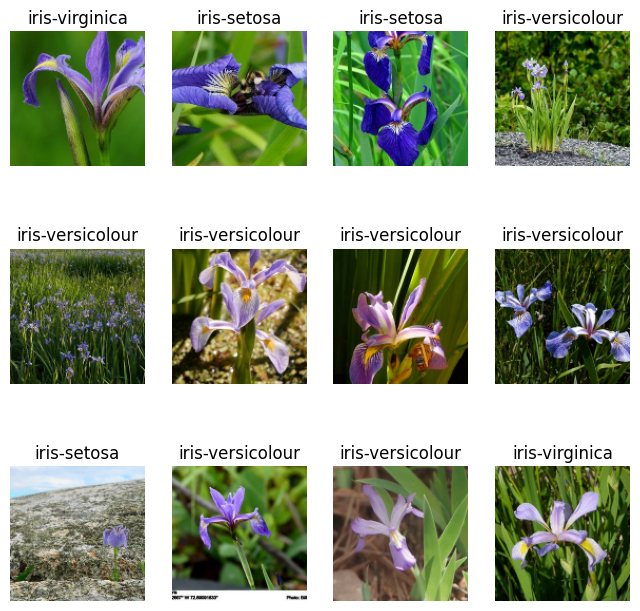

In [8]:
#visualize the dataset
plt.figure(figsize=(8, 8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

27

In [10]:
#function to split the dataset into training , validation and testing data

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

21
2
4


In [13]:
#perform autotune on dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
#define the layers

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [15]:
#compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [16]:
#fit the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
21/21 [==============================] - 31s 1s/step - loss: 26.8623 - accuracy: 0.4769 - val_loss: 1.0313 - val_accuracy: 0.5938
Epoch 2/50
21/21 [==============================] - 17s 834ms/step - loss: 0.9656 - accuracy: 0.6031 - val_loss: 0.9524 - val_accuracy: 0.5625
Epoch 3/50
21/21 [==============================] - 12s 593ms/step - loss: 0.8612 - accuracy: 0.6585 - val_loss: 0.8040 - val_accuracy: 0.6875
Epoch 4/50
21/21 [==============================] - 12s 595ms/step - loss: 0.8439 - accuracy: 0.6677 - val_loss: 0.7451 - val_accuracy: 0.7188
Epoch 5/50
21/21 [==============================] - 18s 870ms/step - loss: 0.7917 - accuracy: 0.6800 - val_loss: 0.8552 - val_accuracy: 0.6875
Epoch 6/50
21/21 [==============================] - 18s 840ms/step - loss: 0.8124 - accuracy: 0.7015 - val_loss: 0.6325 - val_accuracy: 0.6875
Epoch 7/50
21/21 [==============================] - 18s 847ms/step - loss: 0.7206 - accuracy: 0.7077 - val_loss: 0.7422 - val_accuracy: 0.6875
E

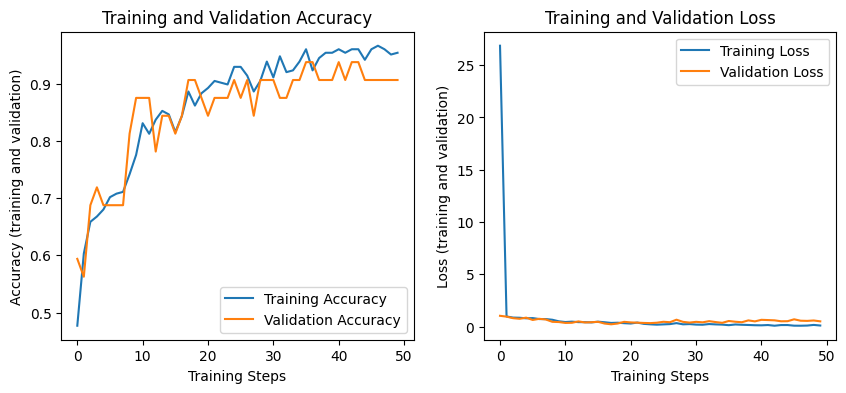

In [20]:
#visulaize the loss and accuracy 

import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [21]:
#get confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predicted labels for the test set
y_true = []
y_pred = []
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(model.predict(x), axis=-1))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

1/1 [==============================] - 0s 134ms/step
[[ 7  2  2]
 [ 0 28  3]
 [ 0  4  7]]


1/1 [==============================] - 0s 250ms/step


Text(0.5, 1.0, 'Confusion Matrix')

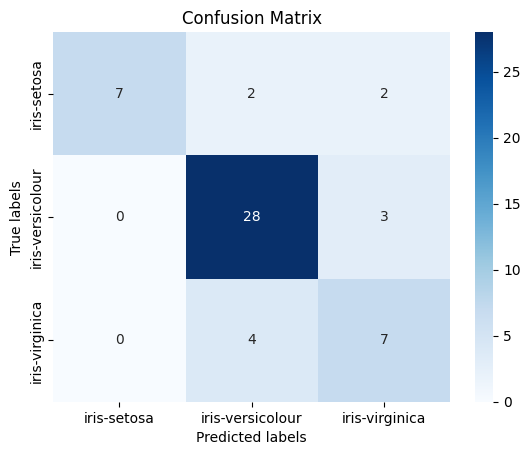

In [22]:
#get confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(model.predict(x), axis=-1))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the labels for the confusion matrix
labels = ['iris-setosa', 'iris-versicolour', 'iris-virginica']

# Create the heatmap with the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')